## 두 가지 랜딩 페이지(구 'old_page', 신 'new_page')의 효과를 비교하기 위한 A/B 테스팅 데이터
* [A/B testing - Kaggle](https://www.kaggle.com/zhangluyuan/ab-testing)
* [renatofillinich/ab_test_guide_in_python](https://github.com/renatofillinich/ab_test_guide_in_python)

* 전환율(Conversion Rate)은 마케팅 및 웹 분석에서 사용하는 중요한 지표로, 특정 행동을 완료한 사용자의 비율을 의미합니다. 웹사이트를 방문한 100명의 사용자 중 5명이 제품을 구매했다면, 전환율은 5%가 됩니다. 
* 전환율은 마케팅 캠페인이나 웹사이트가 얼마나 효과적인지 보기 위한 지표입니다. 전환율은 방문자중에 원하는 행동 (예를들어 구매를 하거나 폼을 작성하는 등) 을 취한 사람의 비율로 계산됩니다. 
* 전환율은 세션 기반으로 산출되므로 실제보다 더 적은 비율처럼 보일 수 있습니다. 예를 들어 뉴스레터 구독 버튼이 1%의 전환율을 보인다면 실제 사용자 중 1%가 전환한 것이 아니라 전체 세션의 1%가 전환을 포함한다는 의미입니다


* 주요 변수
    * user_id: unique id of the user who came to the website
    * timestamp: timestamp that the user came to the page
    * group: whether the user in treatment group or control group
    * landing_page: whether the user saw the old page or new page
    * converted: whether the user converted to a paid user. 1 means converted, 0 means not converted.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

In [2]:
df = pd.read_csv("data/ab_data.csv")
df.shape

(294478, 5)

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
df.tail()

,user_id,timestamp,group,landing_page,converted
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0
294477,715931,2017-01-16 12:40:24.467417,treatment,new_page,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [6]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [7]:
df["month"] = df["timestamp"].dt.month
df["day"] = df["timestamp"].dt.day
df["hour"] = df["timestamp"].dt.hour
df["dayofweek"] = df["timestamp"].dt.dayofweek

In [8]:
session_counts = df["user_id"].value_counts(ascending=False)
session_counts

user_id
805339    2
754884    2
722274    2
783176    2
898232    2
         ..
642985    1
771499    1
923606    1
712675    1
715931    1
Name: count, Length: 290584, dtype: int64

In [9]:
session_counts.unique()

array([2, 1])

In [10]:
session_counts.value_counts()

count
1    286690
2      3894
Name: count, dtype: int64

<Axes: >

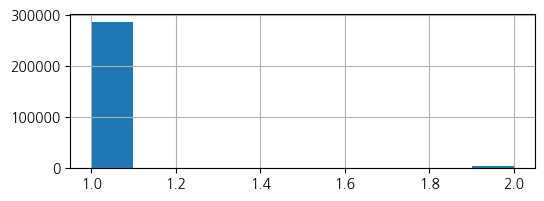

In [11]:
session_counts.hist(figsize=(6, 2))

In [12]:
multi_users = session_counts[session_counts > 1].count()
multi_users

3894

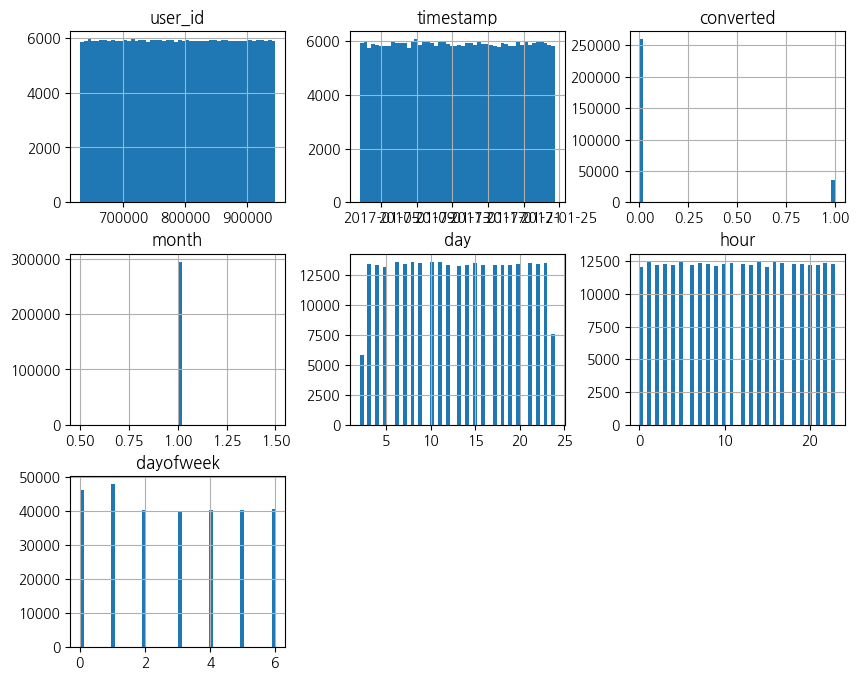

In [13]:
df.hist(bins=50, figsize=(10, 8));

<Axes: xlabel='landing_page', ylabel='count'>

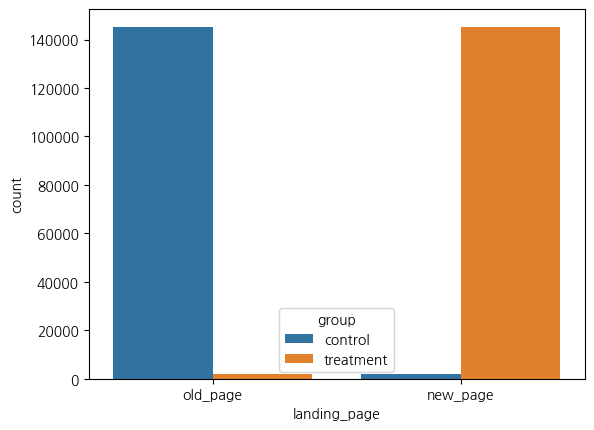

In [14]:
sns.countplot(data=df, x="landing_page", hue="group")

In [15]:
pd.crosstab(df["group"], df["landing_page"])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


<Axes: xlabel='hour'>

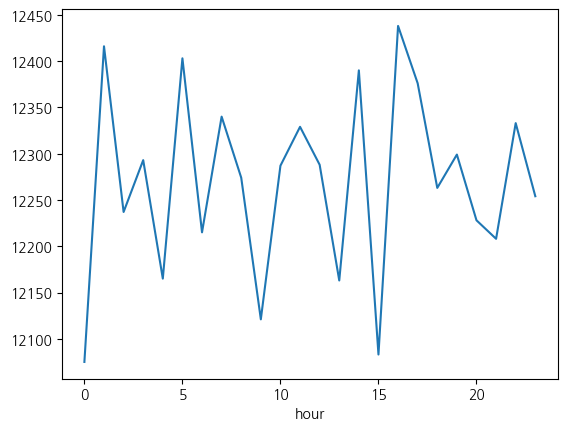

In [16]:
df["hour"].value_counts().sort_index().plot()

<Axes: xlabel='hour'>

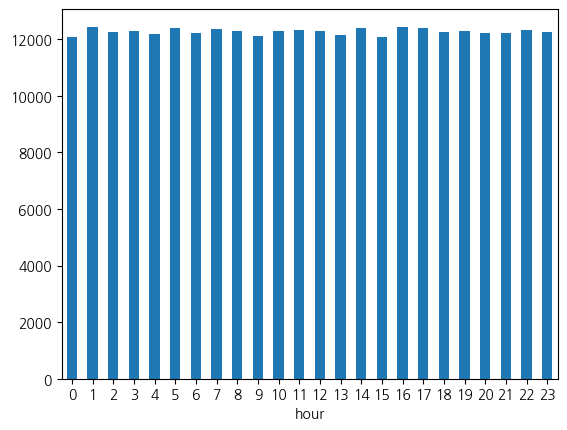

In [17]:
df["hour"].value_counts().sort_index().plot.bar(rot=0)

<Axes: xlabel='dayofweek'>

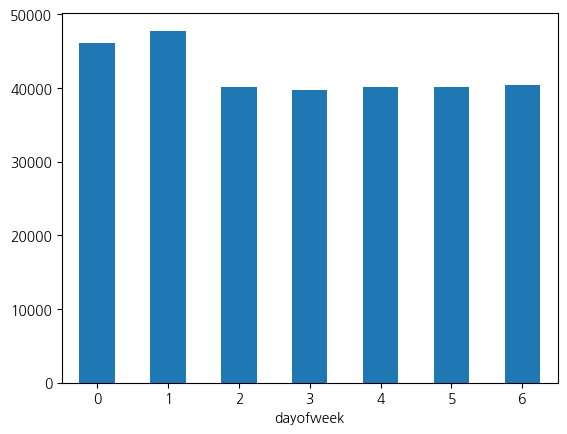

In [18]:
df["dayofweek"].value_counts().sort_index().plot.bar(rot=0)

In [19]:
hwd = pd.crosstab(df["hour"], df["dayofweek"])
hwd.columns = [w for w in "월화수목금토일"]
hwd

,월,화,수,목,금,토,일
hour,,,,,,,
0,1667,2205,1612,1726,1637,1647,1581
1,1750,2307,1668,1681,1663,1671,1676
2,1718,2276,1631,1635,1710,1667,1600
3,1697,2230,1663,1663,1692,1668,1680
4,1652,2231,1660,1592,1680,1688,1662
5,1683,2278,1620,1689,1720,1722,1691
6,1602,2236,1673,1661,1662,1693,1688
7,1687,2213,1684,1689,1654,1671,1742
8,1699,2245,1641,1657,1706,1637,1689


<Axes: ylabel='hour'>

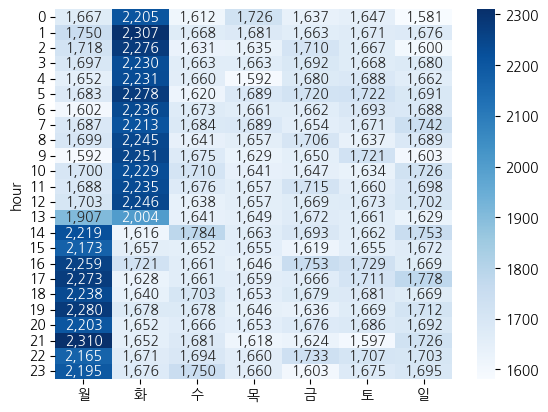

In [20]:
sns.heatmap(hwd, annot=True, fmt=",.0f", cmap="Blues")

<Axes: xlabel='hour'>

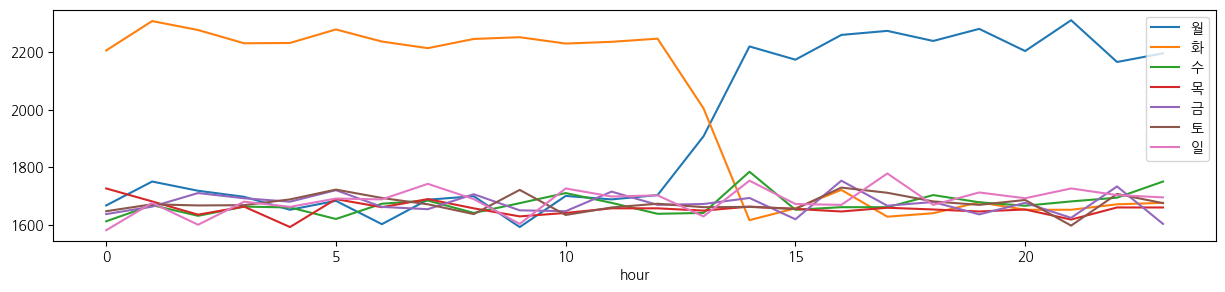

In [21]:
hwd.plot(figsize=(15, 3))

array([<Axes: xlabel='hour'>, <Axes: xlabel='hour'>,
       <Axes: xlabel='hour'>, <Axes: xlabel='hour'>,
       <Axes: xlabel='hour'>, <Axes: xlabel='hour'>,
       <Axes: xlabel='hour'>], dtype=object)

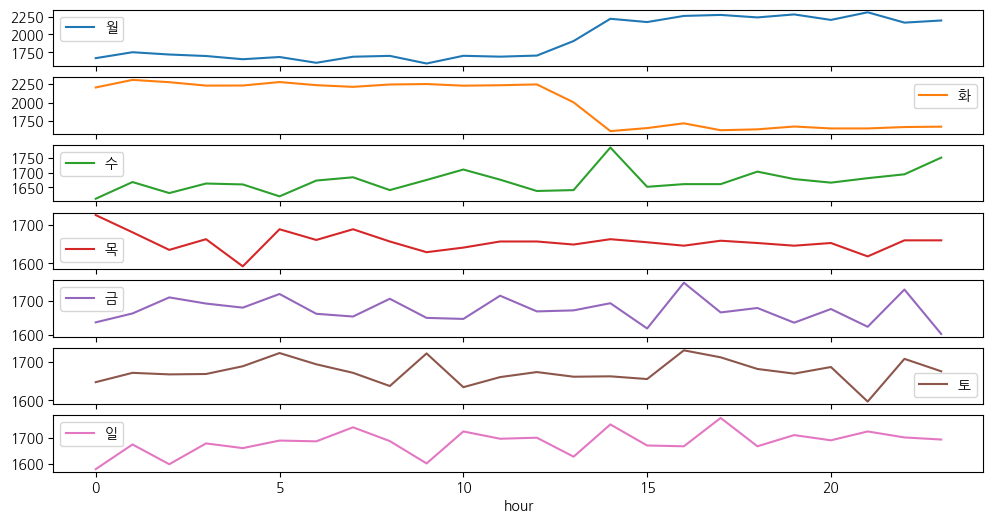

In [22]:
hwd.plot(subplots=True, figsize=(12, 6))

<Axes: xlabel='hour'>

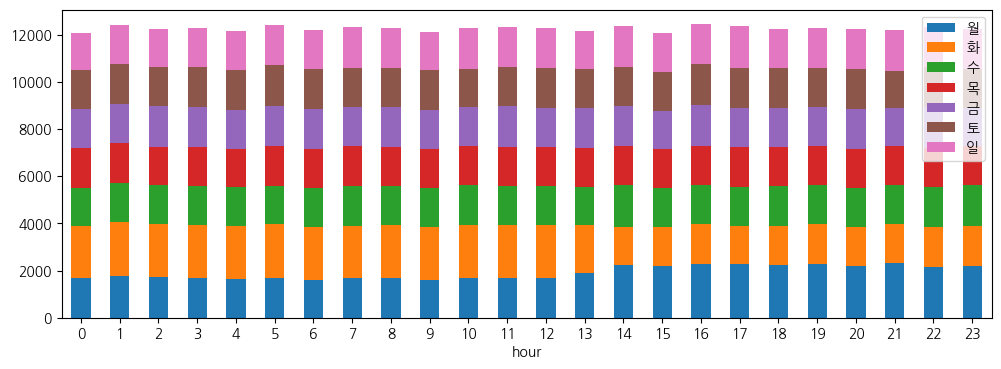

In [23]:
hwd.plot.bar(stacked=True, figsize=(12, 4), rot=0)

<Axes: xlabel='hour', ylabel='count'>

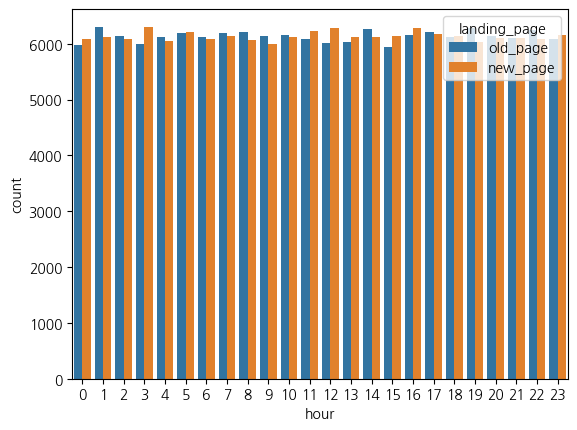

In [24]:
sns.countplot(data=df, x="hour", hue="landing_page")

<Axes: xlabel='dayofweek', ylabel='count'>

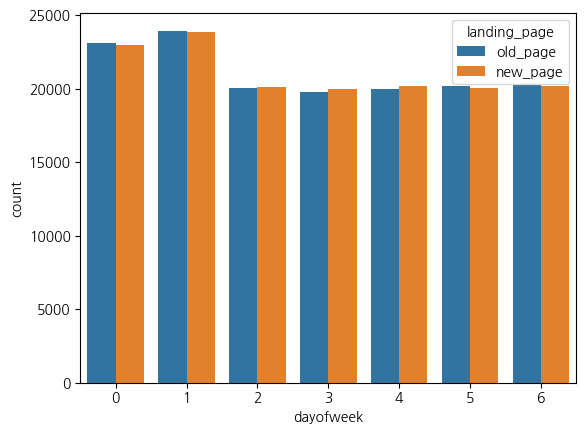

In [25]:
sns.countplot(data=df, x="dayofweek", hue="landing_page")

<Axes: xlabel='day', ylabel='count'>

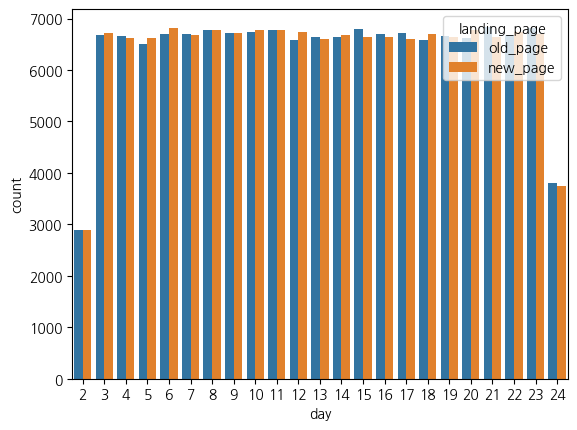

In [26]:
sns.countplot(data=df, x="day", hue="landing_page")

In [27]:
conversion_rates = df.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)
se_p = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.325,0.001
treatment,0.119,0.324,0.001


## 대응표본 t-검정(Paired t-test)과 윌콕슨 부호순위검정(Wilcoxon signed-rank test)


* 대응표본 t-검정
    * 대응표본 t-검정은 변환율과 같은 연속적인 데이터에 대해 두 그룹 간의 평균 차이를 비교할 때 사용됩니다. 
    * 대응표본 t-검정은 두 그룹이 서로 독립적이지 않고, 관련이 있는 경우에 사용됩니다. 
    * 예를 들어, 동일한 사용자가 구 페이지와 신 페이지를 모두 경험했을 때 그들의 변환율을 비교하는 경우입니다. 그러나 제공된 데이터에는 각 사용자가 한 그룹에만 속해 있기 때문에, 이 상황에서는 독립표본 t-검정이 적절할 것입니다.
    * 두 집단 간의 평균 변환율 차이를 비교합니다. 이 경우에는 같은 사용자가 'old_page'와 'new_page'에서의 변환율을 비교하는 것입니다.

* 윌콕슨 부호순위검정
    * 윌콕슨 부호순위검정은 비모수적 방법으로, 데이터가 정규분포를 따르지 않거나 순위 데이터와 같은 비연속적인 경우에 사용됩니다.
    * 윌콕슨 부호순위검정은 두 관련된 그룹 간의 중앙값 차이를 비교할 때 사용됩니다. 이는 데이터가 정규분포를 따르지 않거나, 순위나 범주형 데이터를 다룰 때 유용합니다. 이 경우에도 동일한 사용자가 두 페이지를 모두 경험한 데이터가 필요합니다.
    * 같은 사용자의 'old_page'와 'new_page' 변환율을 비교합니다.

* 검정 과정
    * 사용자가 두 페이지('old_page'와 'new_page') 모두를 경험했는지 확인
    * 이러한 사용자들만을 대상으로 데이터를 재구성
    * 대응표본 t-검정(ttest_rel)과 윌콕슨 부호순위검정(wilcoxon) 수행
    * 결과 해석

In [28]:
# Check if any user has been assigned to both pages
user_group_counts = df.groupby('user_id').landing_page.nunique()
users_with_both_pages = user_group_counts[user_group_counts > 1]

# Number of users assigned to both pages
num_users_with_both_pages = len(users_with_both_pages)
num_users_with_both_pages, users_with_both_pages.head()

(1998,
 user_id
 630052    2
 630126    2
 630137    2
 630471    2
 630780    2
 Name: landing_page, dtype: int64)

In [29]:
# Filter the data to include only users who saw both pages
users_both_pages_data = df[df['user_id'].isin(users_with_both_pages.index)]

# Pivot the data to have columns for old_page and new_page conversion for each user
pivot_data = users_both_pages_data.pivot(index='user_id', columns='landing_page', values='converted')
pivot_data.columns = ['new_page_converted', 'old_page_converted']

# Drop any rows with missing values (if any)
pivot_data.dropna(inplace=True)

# Display the first few rows of the prepared data
pivot_data.head()

,new_page_converted,old_page_converted
user_id,,
630052,0,1
630126,0,0
630137,0,0
630471,0,0
630780,0,0


In [30]:
from scipy.stats import ttest_rel, wilcoxon

# Perform a Paired t-test
t_test_rel_results = ttest_rel(pivot_data['old_page_converted'], pivot_data['new_page_converted'])

# Perform a Wilcoxon Signed-Rank test
wilcoxon_results = wilcoxon(pivot_data['old_page_converted'], pivot_data['new_page_converted'])

# Results
t_test_rel_results, wilcoxon_results

(TtestResult(statistic=0.5655891385497326, pvalue=0.5717366522676408, df=1997),
 WilcoxonResult(statistic=49384.5, pvalue=0.5716076449533316))

두 검정 모두에서 'old_page'와 'new_page' 간의 변환율에 통계적으로 유의미한 차이가 없음을 나타냅니다. 이는 새로운 랜딩 페이지(new_page)가 기존 랜딩 페이지(old_page)보다 변환율 측면에서 유의미한 개선을 보이지 않는다는 것을 의미합니다. 그러나 이러한 결과는 다른 요인들(예: 사용자 행동 패턴, 체류 시간 등)을 고려하지 않았기 때문에, 최종적인 결정을 내리기 전에 추가적인 분석을 고려해야 할 수 있습니다.

## 전환률 비교

In [31]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# control_results와 treatment_results는 각각 'control' 그룹과 'treatment' 그룹의 전환 결과입니다.
# n_con과 n_treat는 각 그룹의 총 관측치 수입니다.
# successes는 각 그룹에서의 전환된(성공한) 경우의 수입니다.
# nobs는 각 그룹의 총 관측치 수의 리스트입니다.
control_results = df[df['group'] == 'control']['converted']
treatment_results = df[df['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.24
p-value: 0.216
ci 95% for control group: [0.119, 0.122]
ci 95% for treatment group: [0.117, 0.121]
